# mTAN - Imputation Model

Here we will test out the mTAN imputation model

In [3]:
# import sys
# path = '../../toy_dataset/'
# sys.path.append(path)

from data_utils import ToyDataset

In [1]:
path_dataset = '/home2/joshua.wendland/Documents/sepsis/toy_dataset/synthetic_ts_1/synthetic_ts_test_data_eav.csv.gz'

# Import, Import, Import

In [2]:
%load_ext autoreload
%autoreload 2

import argparse
import numpy as np
import torch
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

from random import SystemRandom
import models
import utils


/home2/joshua.wendland/Documents/sepsis/sepsis_env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Parse arguments

In [3]:
parser = argparse.ArgumentParser()
parser.add_argument('--niters', type=int, default=2000, help='Number of epochs')
parser.add_argument('--lr', type=float, default=0.01)
parser.add_argument('--std', type=float, default=0.01)
parser.add_argument('--latent-dim', type=int, default=32)
parser.add_argument('--rec-hidden', type=int, default=32)
parser.add_argument('--gen-hidden', type=int, default=50)
parser.add_argument('--embed-time', type=int, default=128)
parser.add_argument('--k-iwae', type=int, default=10)
parser.add_argument('--save', type=int, default=1)
parser.add_argument('--enc', type=str, default='mtan_rnn')
parser.add_argument('--dec', type=str, default='mtan_rnn')
parser.add_argument('--fname', type=str, default=None)
parser.add_argument('--seed', type=int, default=0)
parser.add_argument('--n', type=int, default=8000, help='Number of generated data points')
parser.add_argument('--batch-size', type=int, default=50)
parser.add_argument('--quantization', type=float, default=0.016,
                    help="Quantization on the physionet dataset.")
parser.add_argument('--classif', action='store_true',
                    help="Include binary classification loss")
parser.add_argument('--norm', action='store_true')
parser.add_argument('--kl', action='store_true')
parser.add_argument('--learn-emb', action='store_true')
parser.add_argument('--enc-num-heads', type=int, default=1)
parser.add_argument('--dec-num-heads', type=int, default=1)
parser.add_argument('--length', type=int, default=20)
parser.add_argument('--num-ref-points', type=int, default=128)
parser.add_argument('--dataset', type=str, default='toy')
parser.add_argument('--enc-rnn', action='store_false')
parser.add_argument('--dec-rnn', action='store_false')
parser.add_argument('--sample-tp', type=float, default=1.0)
parser.add_argument('--only-periodic', type=str, default=None)
parser.add_argument('--dropout', type=float, default=0.0)


new_args = ['--niters', '5000', '--lr', '0.001', '--batch-size', '32', '--rec-hidden', '64', '--latent-dim', '16', '--quantization', '0.016', '--enc', 'mtan_rnn', '--dec', 'mtan_rnn', '--n', '8000',  '--gen-hidden', '50', '--save', '1', '--k-iwae', '5', '--std', '0.01', '--norm', '--learn-emb', '--kl', '--seed', '0', '--num-ref-points', '64', '--dataset', 'physionet', '--sample-tp', '0.9']  # original Interpolation task on Physionet data set
new_args = ['--niters', '1000', '--lr', '0.0001', '--batch-size', '128', '--rec-hidden', '32', '--latent-dim', '1', '--length', '20', '--enc', 'mtan_rnn', '--dec', 'mtan_rnn', '--n', '1000',  '--gen-hidden', '50', '--save', '1', '--k-iwae', '5', '--std', '0.01', '--norm', '--learn-emb', '--kl', '--seed', '0', '--num-ref-points', '20', '--dataset', 'toy']  # original Interpolation task on toy dataset
new_args = ['--niters', '5000', '--lr', '0.0001', '--batch-size', '2', '--rec-hidden', '32', '--latent-dim', '4', '--length', '20', '--enc', 'mtan_rnn', '--dec', 'mtan_rnn', '--n', '1000',  '--gen-hidden', '50', '--save', '1', '--k-iwae', '5', '--std', '0.01', '--norm', '--learn-emb', '--kl', '--seed', '0', '--num-ref-points', '20', '--dataset', 'toy_josh'] # interpolation task on josh dataset

args = parser.parse_args(new_args)
print((args))

Namespace(batch_size=2, classif=False, dataset='toy_josh', dec='mtan_rnn', dec_num_heads=1, dec_rnn=True, dropout=0.0, embed_time=128, enc='mtan_rnn', enc_num_heads=1, enc_rnn=True, fname=None, gen_hidden=50, k_iwae=5, kl=True, latent_dim=4, learn_emb=True, length=20, lr=0.0001, n=1000, niters=5000, norm=True, num_ref_points=20, only_periodic=None, quantization=0.016, rec_hidden=32, sample_tp=1.0, save=1, seed=0, std=0.01)


# Set up Dataset

In [4]:
# Set random seeds
experiment_id = int(SystemRandom().random() * 100000)
print(args, experiment_id)
seed = args.seed
torch.manual_seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed(seed)

# Set the device to run calculation on
device = torch.device(
    'cuda' if torch.cuda.is_available() else 'cpu')

# consider the correct dataset
if args.dataset == 'toy':
    data_obj = utils.kernel_smoother_data_gen(args, alpha=100., seed=0)
elif args.dataset == 'toy_josh':
    data_obj = utils.get_toy_data_josh(args, path=path_dataset)

train_loader = data_obj["train_dataloader"]
test_loader = data_obj["test_dataloader"]
dim = data_obj["input_dim"]

Namespace(batch_size=2, classif=False, dataset='toy_josh', dec='mtan_rnn', dec_num_heads=1, dec_rnn=True, dropout=0.0, embed_time=128, enc='mtan_rnn', enc_num_heads=1, enc_rnn=True, fname=None, gen_hidden=50, k_iwae=5, kl=True, latent_dim=4, learn_emb=True, length=20, lr=0.0001, n=1000, niters=5000, norm=True, num_ref_points=20, only_periodic=None, quantization=0.016, rec_hidden=32, sample_tp=1.0, save=1, seed=0, std=0.01) 84705


In [9]:
train_batch = next(iter(train_loader))
train_batch.shape

batch_len = train_batch.shape[0]
observed_data = train_batch[:, :, :dim]
observed_mask = train_batch[:, :, dim:2 * dim]
observed_tp = train_batch[:, :, -1]
print('observed_data.shape', observed_data.dtype)
print('observed_mask.shape', observed_mask.shape)
print('observed_tp.shape', observed_tp.shape)
i = 1
# print(observed_data[i,:5,:])
# print(observed_mask[i,:,:])
(observed_mask == 0).any()

print(observed_tp[0,:])

observed_data.shape torch.float32
observed_mask.shape torch.Size([2, 50, 5])
observed_tp.shape torch.Size([2, 50])
tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27.,
        28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39., 40., 41.,
        42., 43., 44., 45., 46., 47., 48., 49.])


# Set up model

In [7]:
if args.enc == 'enc_rnn3':
    rec = models.enc_rnn3(
        dim, torch.linspace(0, 1., args.num_ref_points), args.latent_dim, 
        args.rec_hidden, 128, learn_emb=args.learn_emb).to(device)
elif args.enc == 'mtan_rnn':
    rec = models.enc_mtan_rnn(
        dim, torch.linspace(0, 1., args.num_ref_points), args.latent_dim, args.rec_hidden, 
        embed_time=128, learn_emb=args.learn_emb, num_heads=args.enc_num_heads).to(device)

    
if args.dec == 'rnn3':
    dec = models.dec_rnn3(
        dim, torch.linspace(0, 1., args.num_ref_points), args.latent_dim, 
        args.gen_hidden, 128, learn_emb=args.learn_emb).to(device)
elif args.dec == 'mtan_rnn':
    dec = models.dec_mtan_rnn(
        dim, torch.linspace(0, 1., args.num_ref_points), args.latent_dim, args.gen_hidden, 
        embed_time=128, learn_emb=args.learn_emb, num_heads=args.dec_num_heads).to(device)

print(f'Encoder: ', args.enc, '\nDecoder: ', args.dec)

Encoder:  mtan_rnn 
Decoder:  mtan_rnn


# Set up optimizer, tensorboard, load model weights (and more?)

In [8]:
params = (list(dec.parameters()) + list(rec.parameters()))
optimizer = optim.Adam(params, lr=args.lr)
print('parameters encoder/decoder:', utils.count_parameters(rec), utils.count_parameters(dec))
if args.fname is not None:
    checkpoint = torch.load(args.fname)
    rec.load_state_dict(checkpoint['rec_state_dict'])
    dec.load_state_dict(checkpoint['dec_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    print('loading saved weights', checkpoint['epoch'])
    print('Test MSE', utils.evaluate(dim, rec, dec, test_loader, args, 1))
    print('Test MSE', utils.evaluate(dim, rec, dec, test_loader, args, 3))
    print('Test MSE', utils.evaluate(dim, rec, dec, test_loader, args, 10))
    print('Test MSE', utils.evaluate(dim, rec, dec, test_loader, args, 20))
    print('Test MSE', utils.evaluate(dim, rec, dec, test_loader, args, 30))
    print('Test MSE', utils.evaluate(dim, rec, dec, test_loader, args, 50))


# Set up Tensorboard
start_time = datetime.now().strftime("%Y.%m.%d-%H.%M.%S")
path = '/home2/joshua.wendland/Documents/sepsis/imputation/mTAN/runs/'
path += f'{args.dataset}/'
path += f'{start_time}/'
writer = SummaryWriter(log_dir=path)
print('Path: ', path)

parameters encoder/decoder: 49962 65485
Path:  /home2/joshua.wendland/Documents/sepsis/imputation/mTAN/runs/toy_josh/2022.12.08-13.44.44/


# Train through epochs

In [47]:
# Run through epochs
for itr in range(1, args.niters + 1):
    train_loss = 0
    train_n = 0
    avg_reconst, avg_kl, mse = 0, 0, 0
    if args.kl:
        wait_until_kl_inc = int(args.niters * 0.4)
        if itr < wait_until_kl_inc:
            kl_coef = 0.
        else:
            kl_coef = (1 - 0.99 ** (itr - wait_until_kl_inc))
        writer.add_scalar('kl_coefficient', kl_coef, itr)
    else:
        kl_coef = 1

    for train_batch in train_loader:
        # get data
        if args.dataset != 'XXtoy_josh':
            train_batch = train_batch.to(device)
            batch_len = train_batch.shape[0]
            observed_data = train_batch[:, :, :dim]
            observed_mask = train_batch[:, :, dim:2 * dim]
            observed_tp = train_batch[:, :, -1]
        else:
            # send to proper device
            train_batch = list(train_batch)
            for i in range(len(train_batch)):
                train_batch[i] = train_batch[i].to(device)
            # give proper variable names
            observed_data, observed_mask, observed_tp, Y = train_batch
            batch_len = observed_data.shape[0]
            # concatenate because original implementation requires it
            train_batch = torch.concatenate(( observed_data, observed_mask, observed_tp.unsqueeze(2)), dim=2)

        if args.sample_tp and args.sample_tp < 1:
            subsampled_data, subsampled_tp, subsampled_mask = utils.subsample_timepoints(
                observed_data.clone(), observed_tp.clone(), observed_mask.clone(), args.sample_tp)
        else:
            subsampled_data, subsampled_tp, subsampled_mask = \
                observed_data, observed_tp, observed_mask
        # --- Forward pass through encoder --- 
        out = rec(torch.cat((subsampled_data, subsampled_mask), 2), subsampled_tp)
        # Interpret the output as mean and log-variance of latent distribution
        qz0_mean = out[:, :, :args.latent_dim]
        qz0_logvar = out[:, :, args.latent_dim:]
        # --- Sampling from latent distribution --- 
        # draw args.kiwae times from the latent distribution
        # epsilon = torch.randn(qz0_mean.size()).to(device)
        epsilon = torch.randn(
            args.k_iwae, qz0_mean.shape[0], qz0_mean.shape[1], qz0_mean.shape[2]
        ).to(device)
        z0 = epsilon * torch.exp(.5 * qz0_logvar) + qz0_mean
        z0 = z0.view(-1, qz0_mean.shape[1], qz0_mean.shape[2])
        # --- forward pass through decoder --- 
        pred_x = dec(
            z0,
            observed_tp[None, :, :].repeat(args.k_iwae, 1, 1).view(-1, observed_tp.shape[1])
        )
        # nsample, batch, seqlen, dim
        pred_x = pred_x.view(args.k_iwae, batch_len, pred_x.shape[1], pred_x.shape[2])
        # --- compute loss --- 
        logpx, analytic_kl = utils.compute_losses(
            dim, train_batch, qz0_mean, qz0_logvar, pred_x, args, device)
        loss = -(torch.logsumexp(logpx - kl_coef * analytic_kl, dim=0).mean(0) - np.log(args.k_iwae))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * batch_len
        train_n += batch_len
        avg_reconst += torch.mean(logpx) * batch_len
        avg_kl += torch.mean(analytic_kl) * batch_len
        mse += utils.mean_squared_error(
            observed_data, pred_x.mean(0), observed_mask) * batch_len

    print('Iter: {}, avg elbo: {:.4f}, avg reconst: {:.4f}, avg kl: {:.4f}, mse: {:.6f}'
        .format(itr, train_loss / train_n, -avg_reconst / train_n, avg_kl / train_n, mse / train_n))
    writer.add_scalar('avg elbo', train_loss / train_n, itr)
    writer.add_scalar('avg reconst', -avg_reconst / train_n, itr)
    writer.add_scalar('avg kl', avg_kl / train_n, itr)
    writer.add_scalar('avg mse', mse / train_n, itr)

    if itr % 10 == 0:
        mse = utils.evaluate(dim, rec, dec, test_loader, args, 1)
        writer.add_scalar('Test MSE', mse, itr)
        print('Test Mean Squared Error', mse)
    if itr % 10 == 0 and args.save:
        path_save = path + args.dataset + '_' + args.enc + '_' + args.dec + '_' + str(experiment_id) + '.h5'
        torch.save({
            'args': args,
            'epoch': itr,
            'rec_state_dict': rec.state_dict(),
            'dec_state_dict': dec.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': -loss,
        }, path_save)
        print("Saved model state.")

Iter: 1, avg elbo: 3670.2501, avg reconst: 3679.9211, avg kl: 0.0022, mse: 0.736694
Iter: 2, avg elbo: 3583.1261, avg reconst: 3592.9473, avg kl: 0.0020, mse: 0.719298
Iter: 3, avg elbo: 3566.6712, avg reconst: 3581.0364, avg kl: 0.0019, mse: 0.716916
Iter: 4, avg elbo: 3569.9828, avg reconst: 3582.5085, avg kl: 0.0018, mse: 0.717212
Iter: 5, avg elbo: 3470.2385, avg reconst: 3488.9829, avg kl: 0.0018, mse: 0.698497
Iter: 6, avg elbo: 3526.9459, avg reconst: 3541.4988, avg kl: 0.0019, mse: 0.709000
Iter: 7, avg elbo: 3432.9336, avg reconst: 3448.7400, avg kl: 0.0021, mse: 0.690443
Iter: 8, avg elbo: 3434.9443, avg reconst: 3450.7415, avg kl: 0.0025, mse: 0.690853
Iter: 9, avg elbo: 3383.1471, avg reconst: 3404.0415, avg kl: 0.0031, mse: 0.681499
Iter: 10, avg elbo: 3367.1892, avg reconst: 3391.0183, avg kl: 0.0039, mse: 0.678875
Test Mean Squared Error tensor(0.6676, device='cuda:0')
Saved model state.
Iter: 11, avg elbo: 3302.1164, avg reconst: 3327.7500, avg kl: 0.0050, mse: 0.666201

# Load and reuse the model for Imputation

Loading and reusing the model can easily be done by following the steps below:

1. Load the data
1. Create the NN models (instantiate classes)  
    - Parse corresponding arguments
2. Load the weights into the models
2. Imputation step  


> **Note:**  
Why do we load the data right after parsing the arguments? -> Because when instantiating the models, they require the `dim` input, which is inferred by using the dataset itself. Of course, it needs to correspond to the original `dim` value used to first create the model checkpoint.

In [26]:
import matplotlib.pyplot as plt
path_dataset = path_dataset
path_model = '/home2/joshua.wendland/Documents/sepsis/imputation/mTAN/runs/toy_josh/2022.12.05-16.49.29/toy_josh_mtan_rnn_mtan_rnn_78688.h5'

# Get dataloader
data_obj = utils.get_toy_data_josh(args, path=path_dataset)
test_loader = data_obj["test_dataloader"]

# Parse arguments
new_args = ['--niters', '5000', '--lr', '0.001', '--batch-size', '32', '--rec-hidden', '64', '--latent-dim', '16', '--quantization', '0.016', '--enc', 'mtan_rnn', '--dec', 'mtan_rnn', '--n', '8000',  '--gen-hidden', '50', '--save', '1', '--k-iwae', '5', '--std', '0.01', '--norm', '--learn-emb', '--kl', '--seed', '0', '--num-ref-points', '64', '--dataset', 'physionet', '--sample-tp', '0.9']  # original Interpolation task on Physionet data set
new_args = ['--niters', '1000', '--lr', '0.0001', '--batch-size', '128', '--rec-hidden', '32', '--latent-dim', '1', '--length', '20', '--enc', 'mtan_rnn', '--dec', 'mtan_rnn', '--n', '1000',  '--gen-hidden', '50', '--save', '1', '--k-iwae', '5', '--std', '0.01', '--norm', '--learn-emb', '--kl', '--seed', '0', '--num-ref-points', '20', '--dataset', 'toy']  # original Interpolation task on toy dataset
new_args = ['--niters', '50', '--lr', '0.0001', '--batch-size', '2', '--rec-hidden', '32', '--latent-dim', '4', '--length', '20', '--enc', 'mtan_rnn', '--dec', 'mtan_rnn', '--n', '1000',  '--gen-hidden', '50', '--save', '1', '--k-iwae', '5', '--std', '0.01', '--norm', '--learn-emb', '--kl', '--seed', '0', '--num-ref-points', '20', '--dataset', 'toy_josh'] # interpolation task on josh dataset
args = parser.parse_args(new_args)
print((args))

# Create model
if args.enc == 'enc_rnn3':
    rec = models.enc_rnn3(
        dim, torch.linspace(0, 1., args.num_ref_points), args.latent_dim, 
        args.rec_hidden, 128, learn_emb=args.learn_emb).to(device)
elif args.enc == 'mtan_rnn':
    rec = models.enc_mtan_rnn(
        dim, torch.linspace(0, 1., args.num_ref_points), args.latent_dim, args.rec_hidden, 
        embed_time=128, learn_emb=args.learn_emb, num_heads=args.enc_num_heads).to(device)
if args.dec == 'rnn3':
    dec = models.dec_rnn3(
        dim, torch.linspace(0, 1., args.num_ref_points), args.latent_dim, 
        args.gen_hidden, 128, learn_emb=args.learn_emb).to(device)
elif args.dec == 'mtan_rnn':
    dec = models.dec_mtan_rnn(
        dim, torch.linspace(0, 1., args.num_ref_points), args.latent_dim, args.gen_hidden, 
        embed_time=128, learn_emb=args.learn_emb, num_heads=args.dec_num_heads).to(device)
print(f'Encoder: ', args.enc, '\nDecoder: ', args.dec)

# load weights into model
checkpoint = torch.load(path_model)
rec.load_state_dict(checkpoint['rec_state_dict'])
dec.load_state_dict(checkpoint['dec_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
print('loading saved weights ...')
print('Model trained until epoch', checkpoint['epoch'])

MSEs_list = list()
for i in range(10):
    MSEs = list()
    k_points = np.concatenate((np.arange(1,10),np.arange(10,101,5)))
    # sample k many times from latent distr. and decode, then evaluate
    for k in k_points:
        mse = utils.evaluate(dim, rec, dec, test_loader, args, k)
        MSEs.append(mse.cpu())
        # print(f'Test MSE\t (k={k:2} samples):\t', mse)
    MSEs_list.append(np.array(MSEs))

MSEs_list = np.array(MSEs_list)
MSEs_mean = np.mean(MSEs_list, axis=0)
MSEs_max = np.max(MSEs_list, axis=0)
MSEs_min = np.min(MSEs_list, axis=0)
MSEs_std = np.std(MSEs_list, axis=0)
argmin = np.argmin(MSEs_mean)

Namespace(batch_size=2, classif=False, dataset='toy_josh', dec='mtan_rnn', dec_num_heads=1, dec_rnn=True, dropout=0.0, embed_time=128, enc='mtan_rnn', enc_num_heads=1, enc_rnn=True, fname=None, gen_hidden=50, k_iwae=5, kl=True, latent_dim=4, learn_emb=True, length=20, lr=0.0001, n=1000, niters=50, norm=True, num_ref_points=20, only_periodic=None, quantization=0.016, rec_hidden=32, sample_tp=1.0, save=1, seed=0, std=0.01)
Encoder:  mtan_rnn 
Decoder:  mtan_rnn
loading saved weights ...
Model trained until epoch 5000


### Visualize

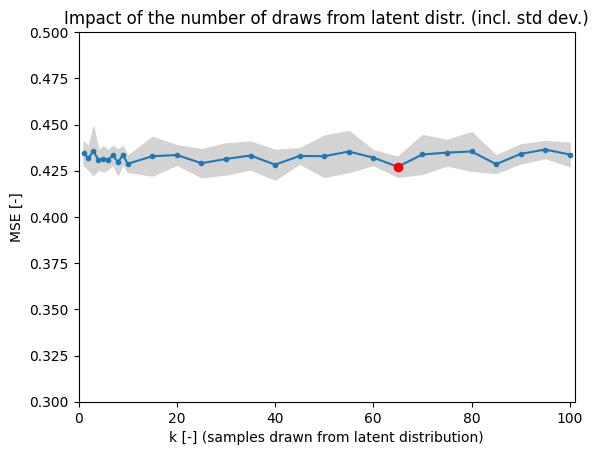

In [22]:
# Visualize results
fig = plt.figure()
plt.plot(k_points, MSEs_mean, marker='o', ms=3)
plt.plot(k_points[argmin], MSEs_mean[argmin], c='r', marker='o')
plt.fill_between(k_points, MSEs_mean+MSEs_std, MSEs_mean-MSEs_std, color='lightgrey')
plt.title('Impact of the number of draws from latent distr. (incl. std dev.)')
plt.xlabel('k [-] (samples drawn from latent distribution)')
plt.ylabel('MSE [-]')
plt.xlim((np.min(k_points)-1, np.max(k_points)+1))
plt.ylim((0.3,0.5))
plt.show()

# Evaluate und different missingness rates


In [28]:
import matplotlib.pyplot as plt
path_dataset = path_dataset
path_model = '/home2/joshua.wendland/Documents/sepsis/imputation/mTAN/runs/toy_josh/2022.12.05-16.49.29/toy_josh_mtan_rnn_mtan_rnn_78688.h5'

# Get dataloader
data_obj = utils.get_toy_data_josh(args, path=path_dataset)
test_loader = data_obj["test_dataloader"]

# Parse arguments
new_args = ['--niters', '5000', '--lr', '0.001', '--batch-size', '32', '--rec-hidden', '64', '--latent-dim', '16', '--quantization', '0.016', '--enc', 'mtan_rnn', '--dec', 'mtan_rnn', '--n', '8000',  '--gen-hidden', '50', '--save', '1', '--k-iwae', '5', '--std', '0.01', '--norm', '--learn-emb', '--kl', '--seed', '0', '--num-ref-points', '64', '--dataset', 'physionet', '--sample-tp', '0.9']  # original Interpolation task on Physionet data set
new_args = ['--niters', '1000', '--lr', '0.0001', '--batch-size', '128', '--rec-hidden', '32', '--latent-dim', '1', '--length', '20', '--enc', 'mtan_rnn', '--dec', 'mtan_rnn', '--n', '1000',  '--gen-hidden', '50', '--save', '1', '--k-iwae', '5', '--std', '0.01', '--norm', '--learn-emb', '--kl', '--seed', '0', '--num-ref-points', '20', '--dataset', 'toy']  # original Interpolation task on toy dataset
new_args = ['--niters', '50', '--lr', '0.0001', '--batch-size', '2', '--rec-hidden', '32', '--latent-dim', '4', '--length', '20', '--enc', 'mtan_rnn', '--dec', 'mtan_rnn', '--n', '1000',  '--gen-hidden', '50', '--save', '1', '--k-iwae', '5', '--std', '0.01', '--norm', '--learn-emb', '--kl', '--seed', '0', '--num-ref-points', '20', '--dataset', 'toy_josh'] # interpolation task on josh dataset
args = parser.parse_args(new_args)
print((args))

# Create model
if args.enc == 'enc_rnn3':
    rec = models.enc_rnn3(
        dim, torch.linspace(0, 1., args.num_ref_points), args.latent_dim, 
        args.rec_hidden, 128, learn_emb=args.learn_emb).to(device)
elif args.enc == 'mtan_rnn':
    rec = models.enc_mtan_rnn(
        dim, torch.linspace(0, 1., args.num_ref_points), args.latent_dim, args.rec_hidden, 
        embed_time=128, learn_emb=args.learn_emb, num_heads=args.enc_num_heads).to(device)
if args.dec == 'rnn3':
    dec = models.dec_rnn3(
        dim, torch.linspace(0, 1., args.num_ref_points), args.latent_dim, 
        args.gen_hidden, 128, learn_emb=args.learn_emb).to(device)
elif args.dec == 'mtan_rnn':
    dec = models.dec_mtan_rnn(
        dim, torch.linspace(0, 1., args.num_ref_points), args.latent_dim, args.gen_hidden, 
        embed_time=128, learn_emb=args.learn_emb, num_heads=args.dec_num_heads).to(device)
print(f'Encoder: ', args.enc, '\nDecoder: ', args.dec)

# load weights into model
checkpoint = torch.load(path_model)
rec.load_state_dict(checkpoint['rec_state_dict'])
dec.load_state_dict(checkpoint['dec_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
print('loading saved weights ...')
print('Model trained until epoch', checkpoint['epoch'])

MSEs = list()
missingnes_rates = np.linspace(0.1,0.9,9)
for m in missingnes_rates:
    data_obj = utils.get_toy_data_josh(args, path=path_dataset, missingness_rate=m)
    test_loader = data_obj["test_dataloader"]
    
    mse = utils.evaluate(dim, rec, dec, test_loader, args, 5)
    MSEs.append(mse.cpu())
        # print(f'Test MSE\t (k={k:2} samples):\t', mse)

print(np.array(MSEs))

Namespace(batch_size=2, classif=False, dataset='toy_josh', dec='mtan_rnn', dec_num_heads=1, dec_rnn=True, dropout=0.0, embed_time=128, enc='mtan_rnn', enc_num_heads=1, enc_rnn=True, fname=None, gen_hidden=50, k_iwae=5, kl=True, latent_dim=4, learn_emb=True, length=20, lr=0.0001, n=1000, niters=50, norm=True, num_ref_points=20, only_periodic=None, quantization=0.016, rec_hidden=32, sample_tp=1.0, save=1, seed=0, std=0.01)
Encoder:  mtan_rnn 
Decoder:  mtan_rnn
loading saved weights ...
Model trained until epoch 5000
[0.43112874 0.43452597 0.45636177 0.49103078 0.49608585 0.5551823
 0.6219458  0.61838096 0.58427805]


# Playground / Temp

In [2]:
import torch as t
import torch as torch

In [106]:
a = np.arange(1,10)
b = np.arange(10,101,10)
np.concatenate((a,b))

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  20,  30,  40,
        50,  60,  70,  80,  90, 100])

In [7]:
from toy_dataset.utils_mTAN import MTAN_ToyDataset

In [9]:
n_features = dim
log_path =  '../../runs/'
mtan = MTAN_ToyDataset(n_features, log_path)

parameters encoder/decoder: 49962 65485


In [15]:
mtan.train_model(train_loader, test_loader, 10)

Iter: 2598, avg elbo: 2335.6810, avg reconst: 2372.3682, avg kl: 2.3394, mse: 0.472233
Iter: 2599, avg elbo: 2388.9559, avg reconst: 2426.7700, avg kl: 2.3678, mse: 0.483025
Iter: 2600, avg elbo: 2430.6507, avg reconst: 2464.3745, avg kl: 2.3170, mse: 0.490752
Test Mean Squared Error tensor(0.4766, device='cuda:0')
Saved model state.
Iter: 2601, avg elbo: 2335.2734, avg reconst: 2370.3525, avg kl: 2.3186, mse: 0.471933
Iter: 2602, avg elbo: 2399.1823, avg reconst: 2438.6799, avg kl: 2.3492, mse: 0.485440
Iter: 2603, avg elbo: 2425.7548, avg reconst: 2463.9880, avg kl: 2.3160, mse: 0.490974
Iter: 2604, avg elbo: 2391.0038, avg reconst: 2437.1560, avg kl: 2.2659, mse: 0.484424
Iter: 2605, avg elbo: 2402.6838, avg reconst: 2424.9844, avg kl: 2.2621, mse: 0.482937
Iter: 2606, avg elbo: 2469.1215, avg reconst: 2509.5537, avg kl: 2.3829, mse: 0.499501
Iter: 2607, avg elbo: 2380.4456, avg reconst: 2419.5298, avg kl: 2.4518, mse: 0.481919
